In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.noise import GaussianNoise
from keras.utils import np_utils
from keras.constraints import maxnorm

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras import backend as K
K.set_image_data_format('channels_first')

import seaborn as sns
sns.set(style="ticks", font_scale=2)

Using TensorFlow backend.


In [2]:
HSC_ids = np.load("HSC_ids.npy")
HSC_ids

array([43158176442374224, 43158176442374373, 43158176442374445, ...,
       43159155694916013, 43159155694916476, 43159155694917496])

In [3]:
X = np.load("images.small.npy")
X.shape

(1866, 3, 50, 50)

In [4]:
X_img = X.copy().transpose([0,2,3,1])
X_img.shape

(1866, 50, 50, 3)

In [5]:
image_size = X.shape[-1]
image_shape = X.shape[1:]
image_size

50

In [6]:
image_shape

(3, 50, 50)

# Get targets

In [7]:
df = pd.read_csv("data/2018_02_23-all_objects.csv")
df = df[df.selected]

df = df.drop_duplicates("HSC_id") \
       .set_index("HSC_id") \
       .loc[HSC_ids] \
       [["photo_z", "log_mass"]]
    

targets = (df.log_mass > 8) & (df.log_mass < 9) & (df.photo_z < .15)
print(targets.mean())
print(targets.sum())

y_conditionals = df.values

0.279206859593
521



# Split training and validation sets

In [8]:
batch_size = 64

In [9]:
np.random.seed(seed=0)
# np.random.seed(12345)
# np.random.seed(seed=np.random.randint(2**32))

randomized_indices = np.arange(X.shape[0])
np.random.shuffle(randomized_indices)

training_fraction = 0.8
# make sure training set size is an even multiple of 64
num_training = (int(training_fraction*X.shape[0]) // batch_size) * batch_size

training_set_indices = randomized_indices[:int(num_training)]
testing_set_indices = np.array(list(set([*randomized_indices]) - set([*training_set_indices])))

In [10]:
testing_set_indices.size


394

In [11]:
training_set_indices.size


1472

# Setup GAN augmentation

In [12]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import array_to_img

In [13]:
# class ImageDataGeneratorSimple(object):
#     """Generate minibatches of image data with real-time GAN data augmentation.
#     A heavily simplified version of `keras.preprocessing.image.ImageDataGenerator`
    
#     # Arguments
#         data_format: 'channels_first' or 'channels_last'. In 'channels_first' mode, the channels dimension
#             (the depth) is at index 1, in 'channels_last' mode it is at index 3.
#             It defaults to the `image_data_format` value found in your
#             Keras config file at `~/.keras/keras.json`.
#             For this project, it should probably be "channels_last".
#     """

#     def __init__(self, data_format="channels_first"):
#         if data_format is None:
#             data_format = K.image_data_format()
#         self.data_format = data_format


#     def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
#              save_to_dir=None, save_prefix='', save_format='png'):
#         return DAGANIterator(
#             x, y, self,
#             batch_size=batch_size,
#             shuffle=shuffle,
#             seed=seed,
#             data_format=self.data_format,
#             save_to_dir=save_to_dir,
#             save_prefix=save_prefix,
#             save_format=save_format,
#         )


In [14]:
class DAGANIterator(Iterator):
    """Iterator yielding data from a DAGAN
    # Arguments
        gan_model: conditional GAN object.
        y_target: Numpy array of targets data.
        y_conditional: Numpy array of conditionals data (for GAN)
            to do: it would be nice to allow this to be a generator.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
        image_shape: array-like, length 3
            example: [3, 50, 50]
            required since I'm not passing any example images to this object
    """

    def __init__(self, gan_model, 
                 y_target, y_conditional,
                 batch_size=64, shuffle=False, seed=None,
                 data_format="channels_first",
                 save_to_dir=None, save_prefix='', save_format='png',
                 image_shape=None):
        if data_format is None:
            raise ValueError("`data_format` cannot be None.")
        self.gan_model = gan_model
        channels_axis = 3 if data_format == 'channels_last' else 1
        if y_target is not None:
            self.y_target = np.asarray(y_target)
        else:
            self.y_target = None
        if y_conditional is not None:
            self.y_conditional = np.asarray(y_conditional)
        else:
            self.y_conditional = None
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        if image_shape is None:
            raise ValueError("`image_shape` must be array-like of length 3")
        self.image_shape = image_shape
        
        if batch_size != self.gan_model.batch_size:
            raise ValueError("DAGANIterator batch_size must match self.gan_model.batch_size.")
        super(DAGANIterator, self).__init__(y_target.shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):        
        y_conditionals = self.y_conditional[index_array]

        batch_x = self.gan_model.generate_samples(y_conditionals)
        
        batch_x = np.asarray(batch_x, dtype=K.floatx())
        batch_x = batch_x.transpose([0,3,1,2])
        
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=j,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y_target is None:
            return batch_x
        batch_y = self.y_target[index_array]
        return batch_x, batch_y

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)



In [15]:
import tensorflow as tf

import gan

In [16]:
sess = tf.Session()
num_epochs = 160
# batch_size = 64 # set above
z_dim = 100
dataset_name = "galaxy"
checkpoint_dir = "checkpoints"
result_dir = "results"
log_dir = "log"

gan_model = gan.CGAN(sess, num_epochs, batch_size, z_dim, dataset_name,
                 image_size, X_img, df.loc[HSC_ids].values,
                 checkpoint_dir, result_dir, log_dir, )

gan_model.build_model()
gan_model.train()


 [*] Reading checkpoints...
 [*] Success to read CGAN.model-4930
 [*] Load SUCCESS


In [17]:
y_conditional_training = y_conditionals[training_set_indices]
y_target_training = targets.values[training_set_indices]

y_target_training.size


1472

In [18]:
dagan_iterator = DAGANIterator(gan_model, y_target_training, y_conditional_training,
                               image_shape=image_shape, 
                               shuffle=True,
             )

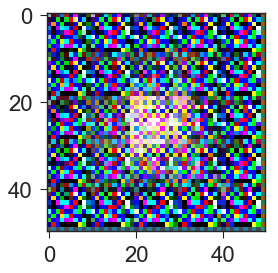

In [19]:
batch_idx = np.arange(64)

y_conditionals_tmp = y_conditionals[batch_idx]

samples = gan_model.generate_samples(y_conditionals_tmp)

plt.imshow(samples[0])

# Setup `keras` model

In [20]:
n_conv_filters = 16
conv_kernel_size = 4
input_shape = X.shape[1:]

dropout_fraction = .25

nb_dense = 64

In [21]:
model = Sequential()

model.add(Conv2D(n_conv_filters, conv_kernel_size,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))


model.add(Conv2D(n_conv_filters, conv_kernel_size*2,
                        padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Conv2D(n_conv_filters, conv_kernel_size*4,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Flatten())
model.add(Dense(2*nb_dense, activation="relu"))
model.add(Dense(nb_dense, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [22]:
learning_rate = 0.001
decay = 1e-5
momentum = 0.9

sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)

adam = Adam(lr=learning_rate)

In [23]:
model.compile(loss='binary_crossentropy', 
#               optimizer=sgd, 
              optimizer=adam,
#               metrics=["accuracy"]
             )

In [24]:
earlystopping = EarlyStopping(monitor='loss',
                              patience=35,
                              verbose=1,
                              mode='auto' )


# Run Basic Keras Model

In [25]:
goal_batch_size = 64
steps_per_epoch = max(2, training_set_indices.size//goal_batch_size)
batch_size = training_set_indices.size//steps_per_epoch
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epochs = 100
verbose=1

steps_per_epoch:  23
batch_size:  64


In [26]:
Y = targets[HSC_ids].values

In [27]:
# %%timeit -r 1 -n 1
history = model.fit_generator(dagan_iterator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=(X[testing_set_indices], Y[testing_set_indices]),
                              verbose=verbose,
                              callbacks=[earlystopping],
                              )  

Epoch 1/100
23/23 [==============================] - 14s 588ms/step - loss: 0.6086 - val_loss: 0.6630
Epoch 2/100
23/23 [==============================] - 12s 517ms/step - loss: 0.5985 - val_loss: 0.6602
Epoch 3/100
23/23 [==============================] - 12s 505ms/step - loss: 0.5972 - val_loss: 0.6467
Epoch 4/100
23/23 [==============================] - 12s 509ms/step - loss: 0.5928 - val_loss: 0.6493
Epoch 5/100
23/23 [==============================] - 12s 510ms/step - loss: 0.5944 - val_loss: 0.6391
Epoch 6/100
23/23 [==============================] - 12s 504ms/step - loss: 0.5976 - val_loss: 0.6458
Epoch 7/100
23/23 [==============================] - 12s 520ms/step - loss: 0.5933 - val_loss: 0.6362
Epoch 8/100
23/23 [==============================] - 12s 515ms/step - loss: 0.5932 - val_loss: 0.6410
Epoch 9/100
23/23 [==============================] - 12s 516ms/step - loss: 0.5947 - val_loss: 0.6306
Epoch 10/100
23/23 [==============================] - 12s 514ms/step - loss: 0.592

23/23 [==============================] - 12s 517ms/step - loss: 0.5909 - val_loss: 0.6017
Epoch 81/100
23/23 [==============================] - 13s 549ms/step - loss: 0.5870 - val_loss: 0.6015
Epoch 82/100
23/23 [==============================] - 13s 549ms/step - loss: 0.5890 - val_loss: 0.6016
Epoch 83/100
23/23 [==============================] - 12s 539ms/step - loss: 0.5865 - val_loss: 0.6015
Epoch 84/100
23/23 [==============================] - 12s 531ms/step - loss: 0.5850 - val_loss: 0.6017
Epoch 85/100
23/23 [==============================] - 12s 542ms/step - loss: 0.5870 - val_loss: 0.6015
Epoch 86/100
23/23 [==============================] - 12s 534ms/step - loss: 0.5876 - val_loss: 0.6016
Epoch 87/100
23/23 [==============================] - 12s 515ms/step - loss: 0.5864 - val_loss: 0.6020
Epoch 88/100
23/23 [==============================] - 12s 521ms/step - loss: 0.5892 - val_loss: 0.6018
Epoch 89/100
23/23 [==============================] - 12s 529ms/step - loss: 0.5873 - 

In [28]:
print("best performance: ", min(history.history["val_loss"]))

best performance:  0.60145004782


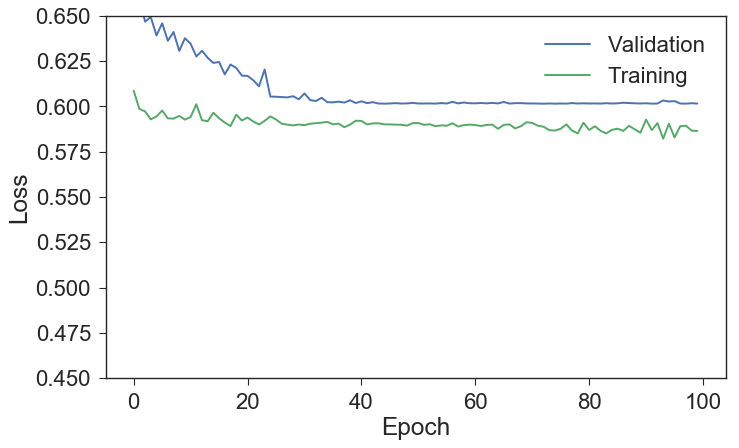

In [29]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):

    plt.plot(history.history["val_loss"], label="Validation")
    plt.plot(history.history["loss"], label="Training")


    plt.legend()
    
    plt.xlabel("Epoch")
#     plt.ylabel("Loss\n(avg. binary cross-entropy)")
    plt.ylabel("Loss")

    
    plt.ylim(.45, .65)

In [30]:
class_probs = model.predict_proba(X[testing_set_indices]).flatten()
class_probs

394/394 [==============================] - 1s 3ms/step


array([ 0.29018906,  0.29025644,  0.29054013,  0.289951  ,  0.28993919,
        0.28968087,  0.28936318,  0.29029921,  0.28958669,  0.29020452,
        0.29023036,  0.29010141,  0.28991252,  0.29003322,  0.28975368,
        0.28971589,  0.28844658,  0.29023021,  0.2898016 ,  0.28993386,
        0.29017842,  0.29028365,  0.29015011,  0.28995526,  0.28995743,
        0.28886357,  0.28984934,  0.28977907,  0.290277  ,  0.29032493,
        0.29084003,  0.2900742 ,  0.28852743,  0.28929833,  0.2889891 ,
        0.2898134 ,  0.28948346,  0.289478  ,  0.28998563,  0.28986996,
        0.29044044,  0.29027963,  0.29021645,  0.2902399 ,  0.29034978,
        0.29003781,  0.29032451,  0.29022193,  0.29008669,  0.29034206,
        0.28940353,  0.29028463,  0.29021522,  0.29035491,  0.28921291,
        0.28869492,  0.28996274,  0.28982541,  0.29025087,  0.29011741,
        0.28970328,  0.28978053,  0.28991947,  0.28953221,  0.29002893,
        0.29017586,  0.28952831,  0.29018968,  0.29023141,  0.28

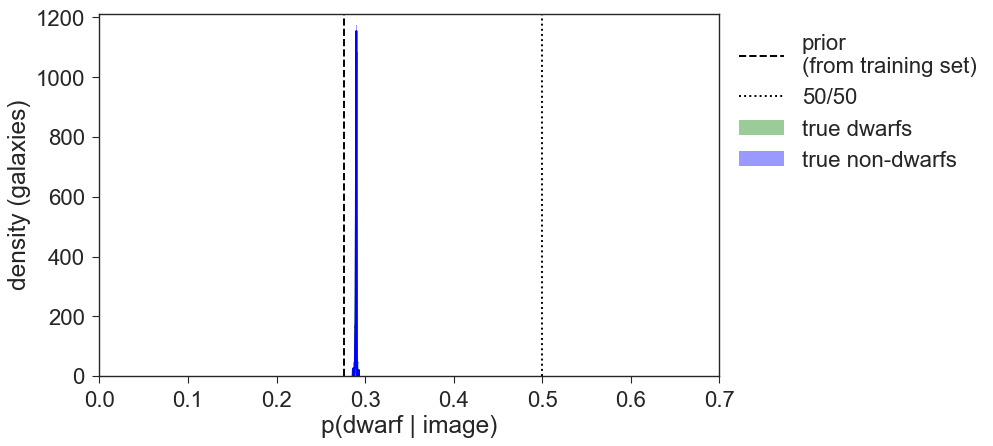

In [31]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    sns.distplot(class_probs[Y[testing_set_indices]==True], color="g", label="true dwarfs")
    sns.distplot(class_probs[Y[testing_set_indices]==False], color="b", label="true non-dwarfs")

    plt.xlabel("p(dwarf | image)")
    plt.ylabel("density (galaxies)")

    plt.xlim(0, .7)
    plt.axvline(Y[training_set_indices].mean(), linestyle="dashed", color="black", label="prior\n(from training set)")
    plt.axvline(.5, linestyle="dotted", color="black", label="50/50")

    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )


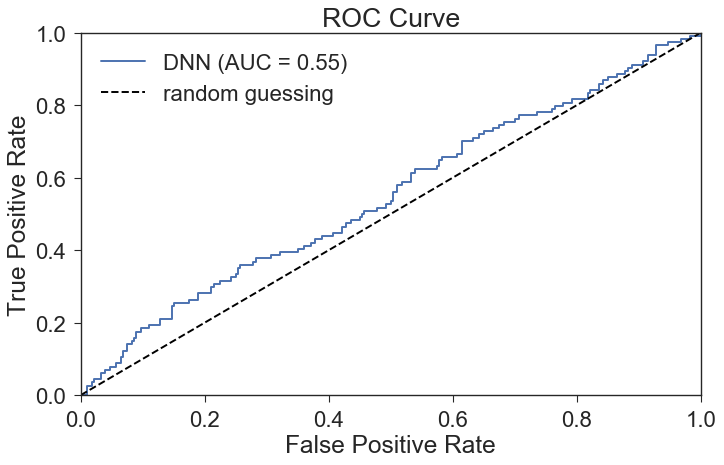

In [32]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    fpr, tpr, _ = metrics.roc_curve(Y[testing_set_indices], class_probs)
    roc_auc = roc_auc_score(Y[testing_set_indices], class_probs)

    plt.plot(fpr, tpr, label="DNN (AUC = {:.2})".format(roc_auc))
    plt.plot([0,1], [0,1], linestyle="dashed", color="black", label="random guessing")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("ROC Curve")

    plt.legend(loc="best")


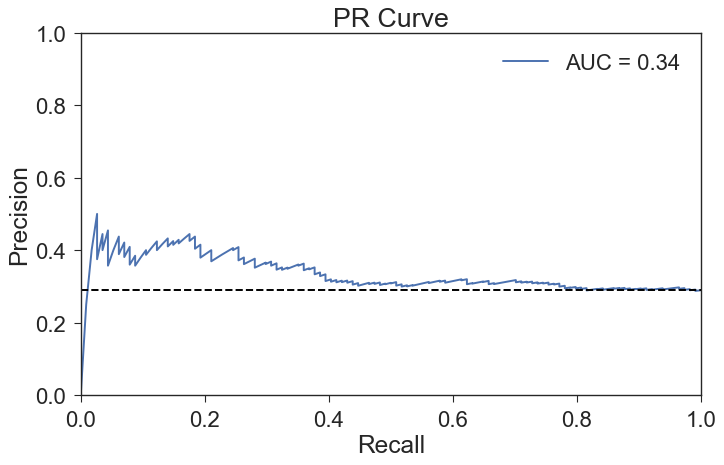

In [33]:
from sklearn import metrics
from sklearn.metrics import average_precision_score
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    precision, recall, _ = metrics.precision_recall_curve(Y[testing_set_indices], class_probs)
    pr_auc = average_precision_score(Y[testing_set_indices], class_probs)

    plt.plot(recall, precision, label="AUC = {:.2}".format(pr_auc))
    plt.plot([0,1], [Y[testing_set_indices].mean()]*2, linestyle="dashed", color="black")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.title("PR Curve")

    plt.legend(loc="best")
